# Predicting Taxi Trip Duration using Machine Learning

<h3>Problem Statement</h3>
<p>To ease travel costs and add to comfort, apps such as Ola and Uber have proven to be some of the most useful technologies we have today. These systems have the ability to gauge how long a driver is occupied on a single ride. In this project, we will build a model that predicts the trip duration of taxis in New York City.</p>

<h3>Analysing the data</h3>
<p>First, let us get a feel for the data we have on hand. We shall take a look at the columns of the data.</p>

<h4>Import Libraries</h4>

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

<h4>Load Data</h4>

In [6]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

<h4>File Details</h4>

In [7]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))
df.iloc[1,:]

Number of rows: 729322
Number of columns: 11


id                              id0889885
vendor_id                               1
pickup_datetime       2016-03-11 23:35:37
dropoff_datetime      2016-03-11 23:53:57
passenger_count                         2
pickup_longitude               -73.988312
pickup_latitude                 40.731743
dropoff_longitude              -73.994751
dropoff_latitude                40.694931
store_and_fwd_flag                      N
trip_duration                        1100
Name: 1, dtype: object

<p>We can see that the columns are as follows.</p>
<ul>
    <li>id - Identifier for each trip</li>
    <li>vendor_id - Identifier for the driver for the trip</li>
    <li>pickup_datetime - The date and time when trip started</li>
    <li>dropoff_datetime  - The date and time when trip ended</li>
    <li>passenger_count - The number of passengers taking the trip</li>
    <li>pickup_longitude - The longitude at which pickup was</li>
    <li>pickup_latitude - The latitude at which pickup was</li>
    <li>dropoff_longitude - The longitude at which dropoff was</li>
    <li>dropoff_latitude - The latitude at which pickup was</li>
    <li>store_and_fwd_flag - Indicates whether the trip record was engaged before pickup due to the vehicle not being connected to the server</li>
    <li>trip_duration - The duration of the trip.</li>
</ul>
<p>We check if the data has any null values.</p>

In [8]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

<p>As we can see, the data has no null values. Now, we convert the data in date and time columns to datetime features and check for any inconsistency in the pickup and dropoff times, whose difference should be equal to the trip duration.</p>

In [9]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

<p>So there is no inconsistency in the data.</p>

<h3>Analysing Target Variable</h3>
<p>We shall explore the details of the target variable, trip duration.</p>

In [8]:
df['trip_duration'].describe()/3600

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

<p>We see that the max duration is high. It is an outlier. To visualise the data better, we will take the log of trip duration.</p>

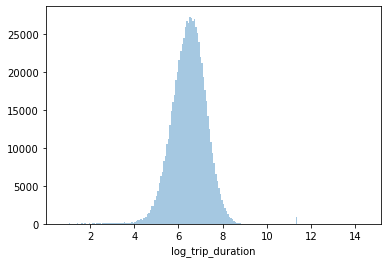

In [11]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

<p>The distribution is mostly normal with a peak at 6.5, which is about 17 minutes. There is an outlier near 12, and there are also several short rides near the start of the distribution.</p>

<p>Let us take a look at some features which may be useful in the later modelling stages.</p>

Text(0, 0.5, 'Frequency')

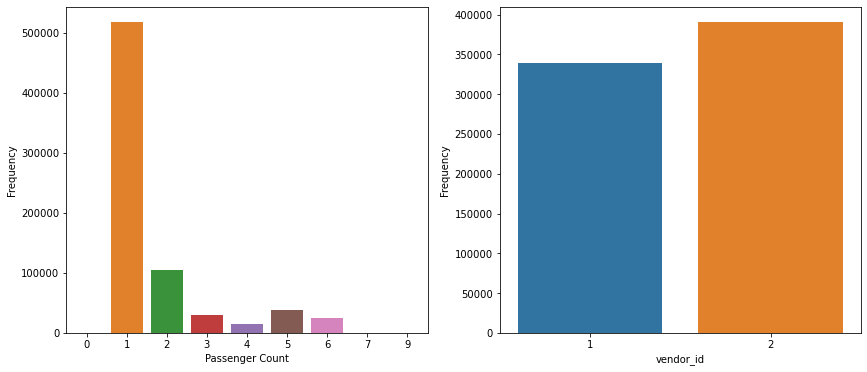

In [17]:
plt.figure(figsize=(22, 6))

#Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


#vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')


<p>We see most trips have one passenger, and the distibution between vendors is mostly same.</p>
<p>Now, we look at some datetime features.</p>

In [18]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

In [19]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

Text(0, 0.5, 'Total number of pickups')

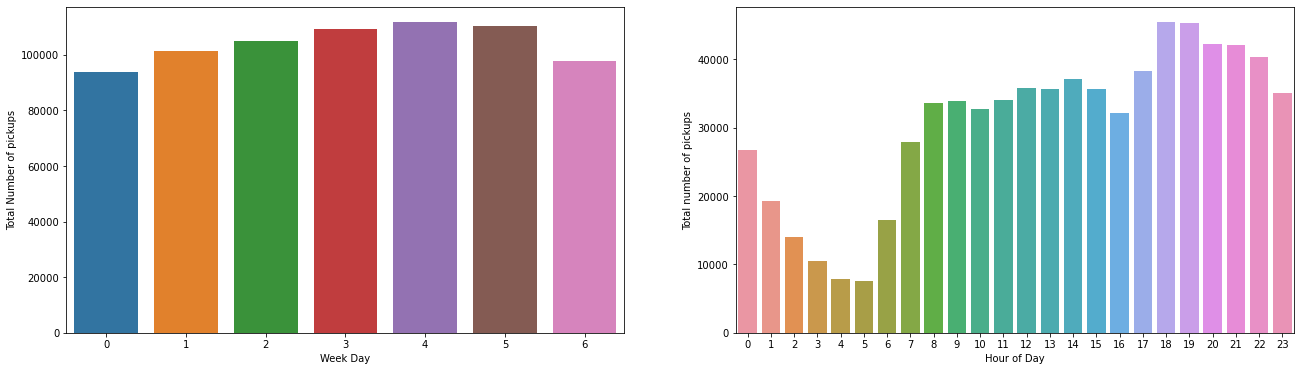

In [20]:
# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(122)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')


<p>Most rides are taken in the middle of the week, i.e. on Wendnesdays and Thursdays.</p>
<p>They are taken in the evening around 7-8pm.</p>

<h4>Latitude and Longitude</h4>
<p>We will check the consistency of geographical data.</p>

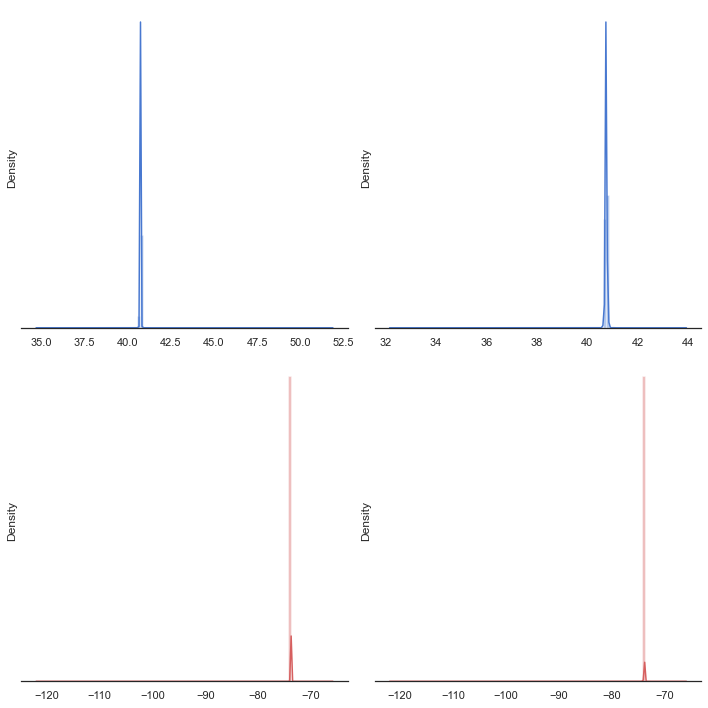

In [21]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

<p>We are not able to visualise the data properly due to the presence of outliers. We can infer that most of the pickups are between the 40 and 41 latitude, and in the -75 to -70 range. Let us drop the outliers and look at our data again.</p>

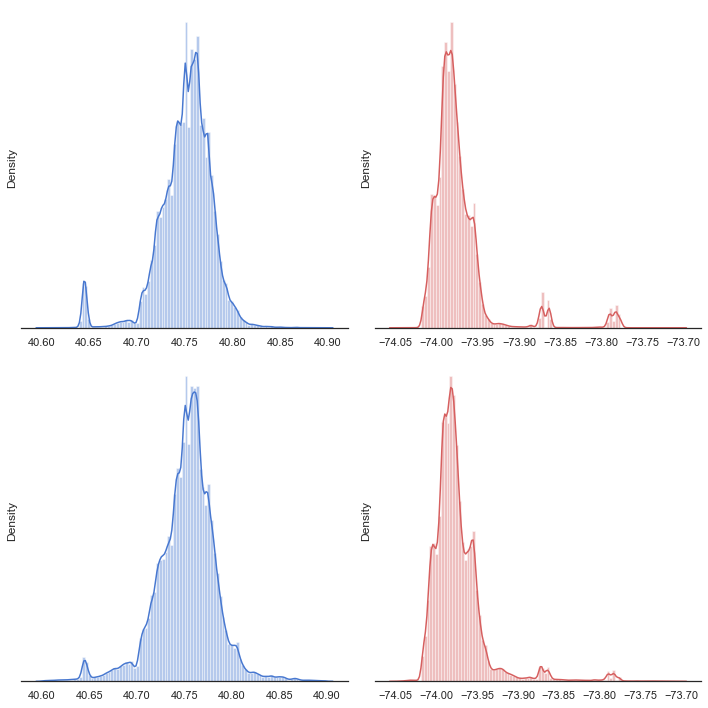

In [22]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

<p>Now, let us take a look at some key variables and their relation with the target variable.</p>

In [24]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'day_of_week', 'hour_of_day'],
      dtype='object')

<h4>Correlation with weekday</h4>
<p>Traffic densities may vary depending on the day of the week. The days of the week are taken as numbers from 0 to 6, 0 being Sunday and 6 being Saturday.</p>

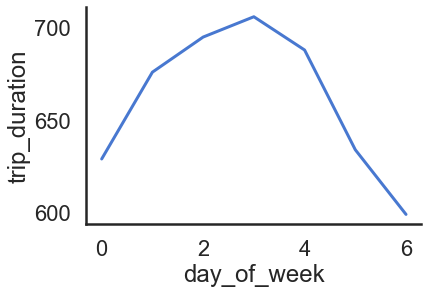

In [25]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(x="day_of_week", y="trip_duration",data=summary_wdays_avg_duration)
sns.despine(bottom = False)

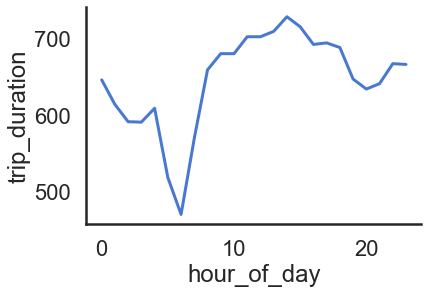

In [26]:
summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(x="hour_of_day", y="trip_duration",data=summary_hourly_avg_duration)
sns.despine(bottom = False)

<p>Trips are shorter in early mornings and late night.</p>

<h4>Correlation with vendor_id</h4>

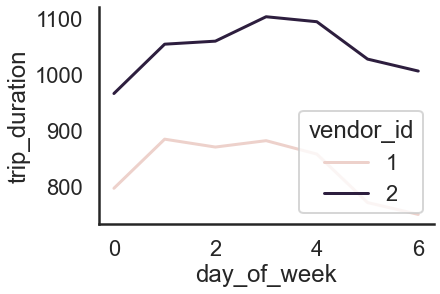

In [27]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(x="day_of_week", y="trip_duration",data=summary_wdays_avg_duration,hue="vendor_id")
sns.despine(bottom = False)


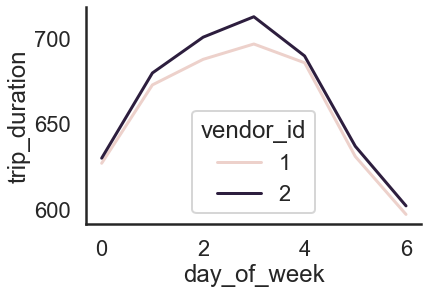

In [28]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(x="day_of_week", y="trip_duration",data=summary_wdays_avg_duration,hue="vendor_id")
sns.despine(bottom = False)

Median trip duration does not vary much for different vendors, as compared to mean trip duration. This could mean there are outliers in vendor 2's data, causing a skewed distribution.

<h4>Correlation with passenger count</h4>

In [29]:
df.passenger_count.value_counts()

1    515243
2    104576
5     38776
3     29561
6     24035
4     13972
0        31
9         1
Name: passenger_count, dtype: int64

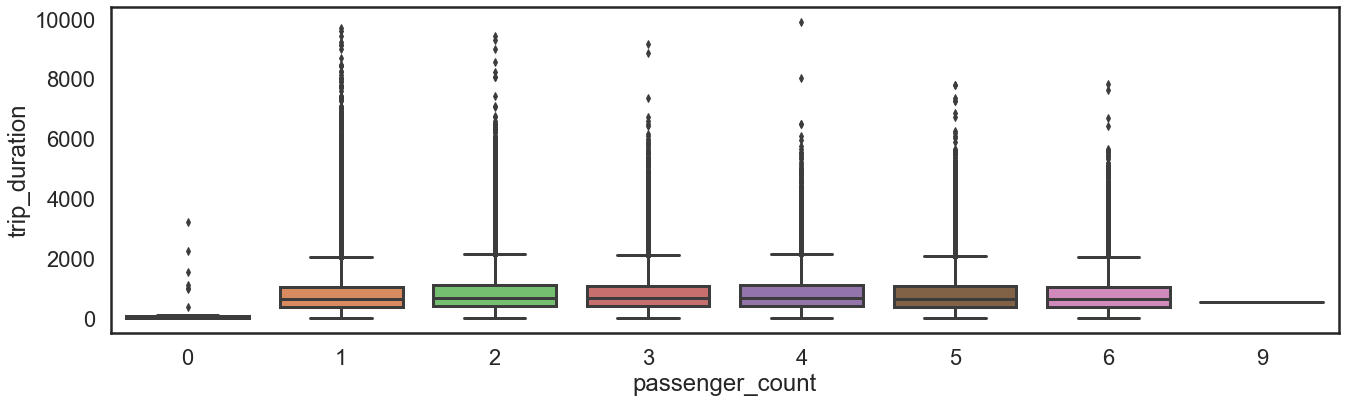

In [31]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()


There is not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3. We also see that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

<h4>Correlation Heatmap</h4>

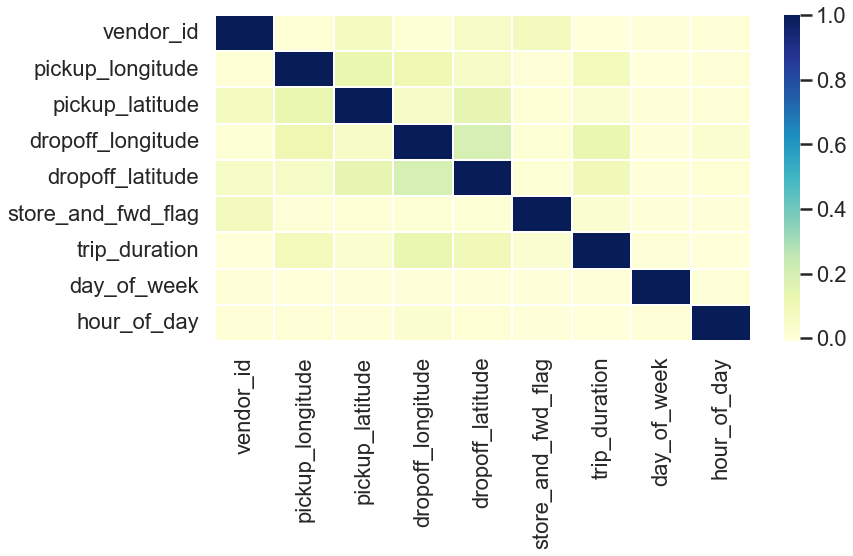

In [31]:
plt.figure(figsize=(12, 6))
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

<h3>From the data, we infer</h3>
<ol>
    <li>The duration of most rides follows a log-normal smooth distribution, with the peak around 17 minutes.</li>
    <li>Majority of the trips have one passenger only.</li>
    <li>The number of trips is more for vendor 2 than vendor 1.</li>
    <li>The peak for pickups is on Thursday.</li>
    <li>The peak time for pickups is in the evenings.</li>
    <li>From the heatmap, latitude and longitude features have more correlation with the target compared to other features.</li>

<h2>Building the Model</h2>

<h4>Import Libraries</h4>

In [34]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

<h4>Load Data</h4>

In [35]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

<h4>Feature Extraction</h4>
<p>Here, some other features such as the pickup minute, pickup day of the year, difference between pickup and dropoff latitudes/longitudes and calculating Haversine distance between the pickup and dropoff coordinates can prove to be helpful.</p>

In [36]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [37]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']


<h4>Distance Features</h4>
Here, we calculate the Harvesine distance between pickup and dropoff points to get an accurate value of the distance covered. Harvesine distance is defined as the angular distance between two points on the surface of a sphere. 

In [37]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

To improve our model, we shall add some external data. We will use data from the Open Source Routing Machine for each trip in our data. OSRM is a modern C++ routing engine for shortest paths in road networks.
The source for OSRM is http://project-osrm.org/

In [39]:
fr1 = pd.read_csv('osrm/fastest_routes_train_part_1.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('osrm/fastest_routes_train_part_2.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


Since latitude and longitude features may contain some noise, we bin them to create new features after rounding their values.

In [40]:
### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

We convert the vendor_id into one hot encoding since the data has values 1 and 2 without any order as IDs.

In [41]:
df['vendor_id'] = df['vendor_id'] - 1

In [42]:
np.sum(pd.isnull(df))

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_weekday              0
pickup_hour_weekofyear      0
pickup_hour                 0
pickup_minute               0
pickup_dt                   0
pickup_week_hour            0
total_distance              1
total_travel_time           1
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64

In [43]:
#Since there is one route without total distance and travel time values available, we fill it with 0.
df.fillna(0, inplace = True) 

In [44]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

We dropped the above features as
<ul>
    <li>id represents a unique value in the data</li>
    <li>We don't need pickup_datetime as we already extracted the features</li>
    <li>We don't use dropoff_dateime as we are trying to predict the difference between it and pickup_datetime</li>
    <li>trip_duration is target variable</li>
    <li>store_and_fwd_flag is not available before the start of trip</li>
</ul>

<h3>Model Building</h3>

In [46]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,total_distance,total_travel_time,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,5157547.0,16,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,6132863.0,119,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,4471099.0,161,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,380597.0,33,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,4084869.0,54,5468.7,645.0,40.708,-74.017,40.741,-73.988


<h4>Defining Metric</h4>

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt

<h4>Test Train Split</h4>
Here, we do a random split, keeping one third of the data in test set and remaining two thirds of data in train set.

In [49]:
#Splitting the data into Train and Validation set
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

<h4>Mean Prediction</h4>
This gives the performance of a basic model that sets the mean of trip duration in train set as the prediction for all trips in test set.

In [50]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.7986672307875027

<h4>Cross Validation</h4>
When we do cross validation, we leave a sample on which the model is not trained and test the model on that sample before the model is finalized.
The data is divided into k equal samples. We train the model on k-1 samples and validate on 1 sample. On the second iteration, validate on a different sample that was not used for training in this iteration.
We do k such iterations. Thus selection bias is reduced along with variance in prediction.

In [51]:
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

<h4>Linear Regression</h4>

In [53]:
linreg_scores = cv_score(LinearRegression())


1 of kfold 5
Valid RMSE: 0.54954

2 of kfold 5
Valid RMSE: 0.55048

3 of kfold 5
Valid RMSE: 0.54939

4 of kfold 5
Valid RMSE: 0.55970

5 of kfold 5
Valid RMSE: 0.54728


As compared with Mean prediction, Linear Regression gives a much better model.

<h4>Decision Tree</h4>

In [54]:
dtree_scores = cv_score(DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25))


1 of kfold 5
Valid RMSE: 0.43550

2 of kfold 5
Valid RMSE: 0.43778

3 of kfold 5
Valid RMSE: 0.42668

4 of kfold 5
Valid RMSE: 0.43251

5 of kfold 5
Valid RMSE: 0.42930


We see the Decision Tree model behaves even better than the Linear Regression model.

In [55]:
results_df = pd.DataFrame({'linear_regression':linreg_scores, 'dtree': dtree_scores})

We plot the difference in performance between the models.

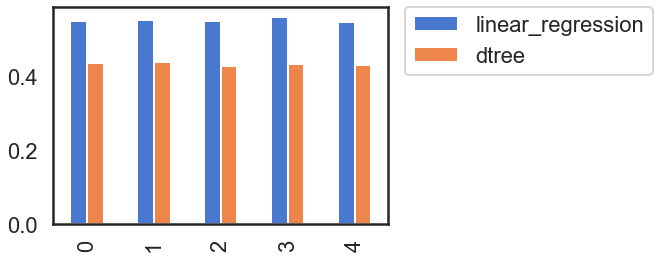

In [56]:
results_df.plot(y=["linear_regression", "dtree"], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The reason for the difference in performance of models could be the non-linear relationship between the trip duration values and the coordinates of pickup and dropoff points.